# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

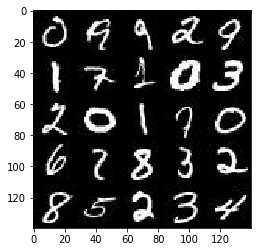

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

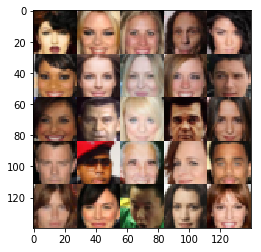

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [93]:
def discriminator(images, reuse=False):
    
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [101]:
def generator(z, out_channel_dim, is_train=True):
    alpha=0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [107]:
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
  
    smooth = 0.01
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [108]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars) 
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [109]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [110]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    samples, losses = [], []
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, lr:learning_rate})
               
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 50, input_z, data_shape[3], data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2486... Generator Loss: 2.2280
Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 2.1260
Epoch 1/2... Discriminator Loss: 2.3613... Generator Loss: 0.3938
Epoch 1/2... Discriminator Loss: 2.3257... Generator Loss: 0.2626
Epoch 1/2... Discriminator Loss: 2.3571... Generator Loss: 0.2306
Epoch 1/2... Discriminator Loss: 2.3847... Generator Loss: 0.2639
Epoch 1/2... Discriminator Loss: 2.2726... Generator Loss: 0.2458
Epoch 1/2... Discriminator Loss: 1.9801... Generator Loss: 0.4382
Epoch 1/2... Discriminator Loss: 2.1263... Generator Loss: 0.4320
Epoch 1/2... Discriminator Loss: 1.9049... Generator Loss: 0.5343


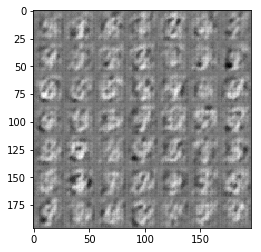

Epoch 1/2... Discriminator Loss: 1.9797... Generator Loss: 0.5503
Epoch 1/2... Discriminator Loss: 2.1248... Generator Loss: 0.1984
Epoch 1/2... Discriminator Loss: 1.7469... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 1.8007... Generator Loss: 0.3023
Epoch 1/2... Discriminator Loss: 1.9052... Generator Loss: 0.4511
Epoch 1/2... Discriminator Loss: 1.7047... Generator Loss: 0.3935
Epoch 1/2... Discriminator Loss: 1.5487... Generator Loss: 0.7373
Epoch 1/2... Discriminator Loss: 1.6203... Generator Loss: 0.4057
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.5641
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 1.1551


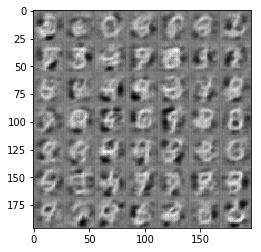

Epoch 1/2... Discriminator Loss: 1.8854... Generator Loss: 0.2660
Epoch 1/2... Discriminator Loss: 1.7504... Generator Loss: 0.3248
Epoch 1/2... Discriminator Loss: 1.5883... Generator Loss: 0.4316
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.6263... Generator Loss: 0.4757
Epoch 1/2... Discriminator Loss: 1.5560... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 1.7162... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.8252... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.5543
Epoch 1/2... Discriminator Loss: 1.5830... Generator Loss: 0.4874


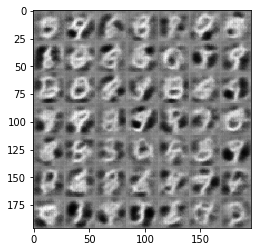

Epoch 1/2... Discriminator Loss: 1.7365... Generator Loss: 0.2933
Epoch 1/2... Discriminator Loss: 1.5877... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.5942... Generator Loss: 0.6606
Epoch 1/2... Discriminator Loss: 1.5194... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.7065... Generator Loss: 0.2905
Epoch 1/2... Discriminator Loss: 1.7410... Generator Loss: 0.3828
Epoch 1/2... Discriminator Loss: 1.5513... Generator Loss: 0.4073
Epoch 1/2... Discriminator Loss: 1.6673... Generator Loss: 0.3443
Epoch 1/2... Discriminator Loss: 1.6657... Generator Loss: 0.3525
Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 0.7339


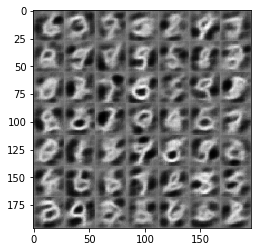

Epoch 1/2... Discriminator Loss: 1.6272... Generator Loss: 0.9287
Epoch 1/2... Discriminator Loss: 1.5322... Generator Loss: 0.5478
Epoch 1/2... Discriminator Loss: 1.5821... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.3577
Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 1.4810... Generator Loss: 0.9248
Epoch 2/2... Discriminator Loss: 1.6133... Generator Loss: 0.3329
Epoch 2/2... Discriminator Loss: 1.4298... Generator Loss: 0.5363
Epoch 2/2... Discriminator Loss: 1.4884... Generator Loss: 0.6684
Epoch 2/2... Discriminator Loss: 1.5762... Generator Loss: 0.3939


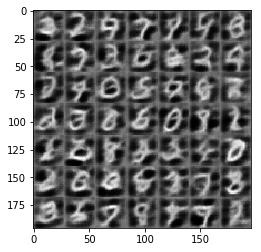

Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 0.5660
Epoch 2/2... Discriminator Loss: 1.5503... Generator Loss: 0.9815
Epoch 2/2... Discriminator Loss: 1.7495... Generator Loss: 0.2583
Epoch 2/2... Discriminator Loss: 1.6749... Generator Loss: 0.3021
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.6536
Epoch 2/2... Discriminator Loss: 1.5804... Generator Loss: 0.3278
Epoch 2/2... Discriminator Loss: 2.3623... Generator Loss: 0.1242
Epoch 2/2... Discriminator Loss: 1.5125... Generator Loss: 0.4473
Epoch 2/2... Discriminator Loss: 1.4696... Generator Loss: 0.5165


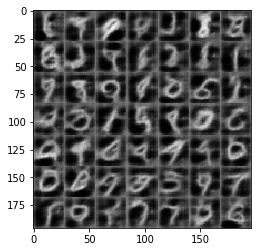

Epoch 2/2... Discriminator Loss: 1.5632... Generator Loss: 0.8403
Epoch 2/2... Discriminator Loss: 1.5037... Generator Loss: 0.4865
Epoch 2/2... Discriminator Loss: 1.4765... Generator Loss: 0.4037
Epoch 2/2... Discriminator Loss: 1.4371... Generator Loss: 0.4670
Epoch 2/2... Discriminator Loss: 1.5413... Generator Loss: 0.3646
Epoch 2/2... Discriminator Loss: 1.4045... Generator Loss: 0.5783
Epoch 2/2... Discriminator Loss: 1.5069... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 1.5394... Generator Loss: 0.4132
Epoch 2/2... Discriminator Loss: 1.4493... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.6296


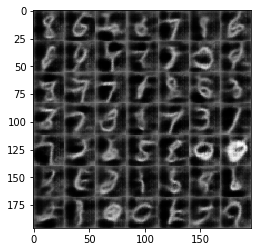

Epoch 2/2... Discriminator Loss: 1.7253... Generator Loss: 0.2623
Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 0.6592
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.5447
Epoch 2/2... Discriminator Loss: 1.9608... Generator Loss: 0.1852
Epoch 2/2... Discriminator Loss: 1.4417... Generator Loss: 0.7745
Epoch 2/2... Discriminator Loss: 1.5596... Generator Loss: 0.5216
Epoch 2/2... Discriminator Loss: 1.5096... Generator Loss: 0.6063
Epoch 2/2... Discriminator Loss: 1.5880... Generator Loss: 0.8133
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 0.4796


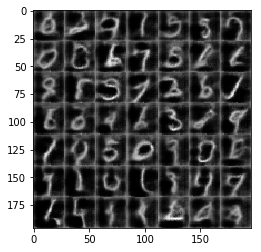

Epoch 2/2... Discriminator Loss: 1.7888... Generator Loss: 0.2464
Epoch 2/2... Discriminator Loss: 1.4240... Generator Loss: 0.4702
Epoch 2/2... Discriminator Loss: 1.6981... Generator Loss: 0.8733
Epoch 2/2... Discriminator Loss: 1.4903... Generator Loss: 1.1909
Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 2.0844... Generator Loss: 0.1604
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.5296
Epoch 2/2... Discriminator Loss: 1.5547... Generator Loss: 0.2960
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.4796


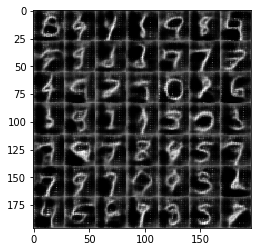

Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.6224
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.4159


In [113]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 2.1557... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.9508... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 2.5540... Generator Loss: 0.1314
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.9799... Generator Loss: 0.3154
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.4657


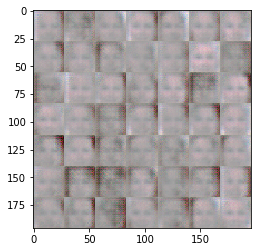

Epoch 1/1... Discriminator Loss: 1.9078... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 2.1169... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 2.1650... Generator Loss: 0.4420
Epoch 1/1... Discriminator Loss: 1.6744... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 2.2264... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 2.1818... Generator Loss: 0.3695
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 2.3066... Generator Loss: 0.2735
Epoch 1/1... Discriminator Loss: 1.8572... Generator Loss: 0.4820


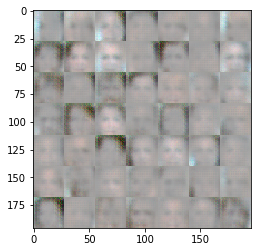

Epoch 1/1... Discriminator Loss: 2.0483... Generator Loss: 0.3655
Epoch 1/1... Discriminator Loss: 1.7659... Generator Loss: 0.3440
Epoch 1/1... Discriminator Loss: 1.7050... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.8518... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.8384... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 1.7024... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.8140... Generator Loss: 0.4521


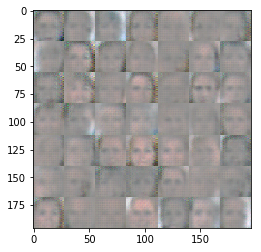

Epoch 1/1... Discriminator Loss: 1.8283... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.6787... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.8495... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 1.7012... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.7327... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.6611... Generator Loss: 0.5926


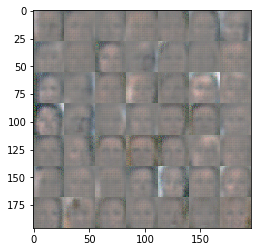

Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.7466... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.6913... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.5209


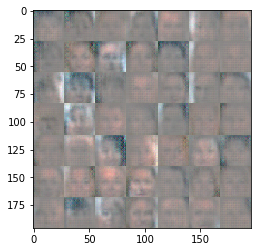

Epoch 1/1... Discriminator Loss: 1.6809... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.5698


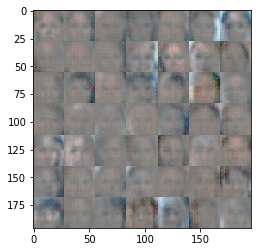

Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.6008... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.6562... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.6496... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.6032


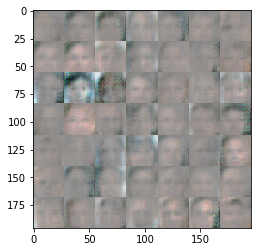

Epoch 1/1... Discriminator Loss: 1.6346... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6602


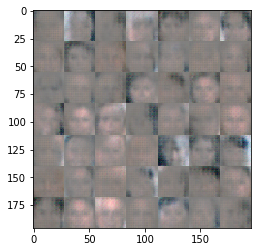

Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.5955... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6704


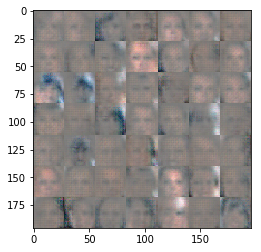

Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.6232... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.5737


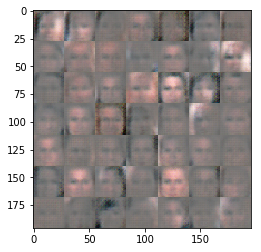

Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.7126... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5340


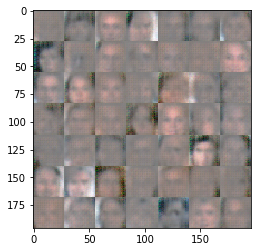

Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 2.0279... Generator Loss: 0.1943
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.3011
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.6702... Generator Loss: 0.3597


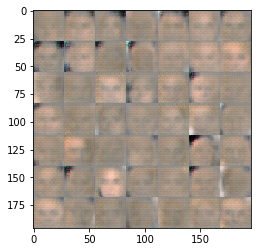

Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.8073... Generator Loss: 0.2887
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7447


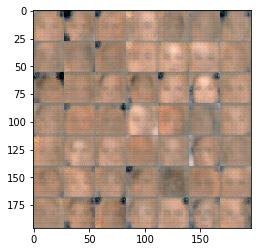

Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.6265... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.6687... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.6641... Generator Loss: 0.3508
Epoch 1/1... Discriminator Loss: 1.6485... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.5949


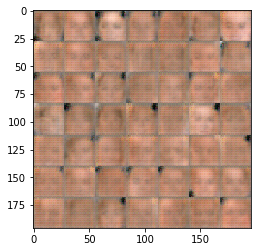

Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.5378


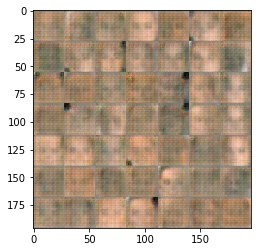

Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.6813... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.5861


In [114]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.